In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport utils

In [3]:
from PIL import Image
from skimage.feature import local_binary_pattern, hog, greycomatrix, greycoprops
from skimage.filters import gabor_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from scipy import ndimage, linalg
from tqdm import tqdm
import numpy as np
import glob
from torch.nn.functional import logsigmoid
import torch.nn as nn
import torch
import random
import heapq
import matplotlib.pyplot as plt
import math
from utils import create_dataset, random_crop
import itertools

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [5]:
root = './FaceMask166/'
methods = ['lbp','HOG','zernike_p']
split = 'D'
path_template_train = './features/features_split_{}_ff_{}_{}_cropenable_{}_ncrops_{}_noise_{}.pkl'
path_template_val_test = './features/features_split_{}_ff_{}_{}.pkl'
full_face = False
crop_enable = True
n_crops = 5
noise = 20

In [34]:
X_train, gt_train, X_val, gt_val, X_test, gt_test, train_imgs_path, val_imgs_path,\
test_imgs_path, img_train, img_val, img_test = create_dataset(root=root,
                                                              methods=methods,
                                                              split=split,                                                              
                                                              path_template_train=path_template_train,
                                                              path_template_val_test=path_template_val_test,
                                                              full_face=full_face,
                                                              crop_enable = crop_enable,
                                                              n_crops = n_crops,
                                                              noise = noise)

Features de Train
feature file loaded
Features de Val
feature file loaded
Features de Test
feature file loaded


In [35]:
scaler_nmf = StandardScaler()
scaler_nmf.fit(X_train)
X_train = scaler_nmf.transform(X_train)
X_val = scaler_nmf.transform(X_val)
X_test = scaler_nmf.transform(X_test)

In [36]:
print("Num feature: ", X_train.shape[1])

Num feature:  109533


In [37]:
pca_feat = PCA(n_components=35, whiten=True).fit(X_train)

In [38]:
X_train_f_p = pca_feat.transform(X_train)
X_val_f_p = pca_feat.transform(X_val)
X_test_f_p = pca_feat.transform(X_test)

In [39]:
clf = ExtraTreesClassifier(n_estimators=300, random_state = 7).fit(X_train, gt_train)
model = SelectFromModel(clf, prefit=True)
X_train = model.transform(X_train)
X_val = model.transform(X_val)
X_test = model.transform(X_test)

In [40]:
print("Num feature: ", X_train.shape[1])

Num feature:  46698


In [41]:
X_train = np.concatenate([X_train, X_train_f_p], axis = 1)
X_val = np.concatenate([X_val, X_val_f_p], axis = 1)
X_test = np.concatenate([X_test, X_test_f_p], axis = 1)

In [42]:
print("Num feature: ", X_train.shape[1])

Num feature:  46733


In [43]:
X_train.shape

(2490, 46733)

In [ ]:
svm = LinearSVC(random_state=0, tol=1e-05).fit(X_train, gt_train)

y_pred_train_svm = svm.predict(X_train)
acc_train_svm = np.sum(y_pred_train_svm == gt_train)/(gt_train.shape[0])*100

y_pred_svm = svm.predict(X_val)
acc_val_svm = np.sum(y_pred_svm == gt_val)/(gt_val.shape[0])*100

y_pred_t_svm = svm.predict(X_test)
acc_test_svm = np.sum(y_pred_t_svm == gt_test)/(gt_test.shape[0])*100

In [ ]:
print("acc_train_svm: ", acc_train_svm)
print("acc_val_svm: ", acc_val_svm)
print("acc_test_svm: ", acc_test_svm)

In [44]:
sorted_idxs = gt_train.argsort()
X_train_sorted = X_train[sorted_idxs]
gt_train_sorted = gt_train[sorted_idxs]
img_train_sorted = img_train[sorted_idxs]

In [83]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        assert len(layer_sizes) >= 2
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes)-1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
    def forward(self, X):
        n = len(self.layers)
        for i in range(n-1):
            X = torch.relu(self.layers[i](X))
        X = self.layers[-1](X)
        return X

In [94]:
def get_training_triplet_samples__exact(m, n_imgs_per_person=3):
    triplets = []
    for i in range(m):
        for k1 in range(n_imgs_per_person):
            for k2 in range(k1+1, n_imgs_per_person):
                for j in range(m):
                    if i == j:
                        continue
                    for k3 in range(n_imgs_per_person):
                        a = i*n_imgs_per_person+k1
                        b = i*n_imgs_per_person+k2
                        c = j*n_imgs_per_person+k3
                        triplets.append((a,b,c))
                        triplets.append((b,a,c))
    random.shuffle(triplets)
    print('%d triplets' % len(triplets))
    return triplets

def get_training_triplet_samples__random(m, n_samples, n_imgs_per_person=3):
    n_samples_per_person = math.ceil(n_samples / (m * (m-1) * n_imgs_per_person * (n_imgs_per_person-1) ))
    triplets = []
    idxs = list(range(n_imgs_per_person))
    for i in range(m):
        for k1 in range(n_imgs_per_person):
            a = i*n_imgs_per_person+k1            
            for k2 in range(n_imgs_per_person):
                if k1 == k2:
                    continue
                b = i*n_imgs_per_person+k2
                for j in range(m):
                    if i == j:
                        continue
                    if n_samples_per_person < n_imgs_per_person:
                        _idxs = random.sample(idxs, n_samples_per_person)
                    else:
                        _idxs = idxs                        
                    for k3 in _idxs:                        
                        c = j*n_imgs_per_person+k3
                        triplets.append((a,b,c))
    random.shuffle(triplets)
    print('%d triplets' % len(triplets))
    return triplets

In [95]:
def triplet_margin_loss_forward(anchor, pos, neg, margin):
    dist2_pos = torch.sum((anchor - pos)**2, dim=1)
    dist2_neg = torch.sum((anchor - neg)**2, dim=1)
    delta = dist2_pos - dist2_neg
    loss = torch.mean(torch.clamp(delta + margin, min=0.))
    correctly_ranked = delta < 0.
    return loss, correctly_ranked

def triplet_crossentropy_loss_forward(anchor, pos, neg):
    dist2_pos = torch.sum((anchor - pos)**2, dim=1)
    dist2_neg = torch.sum((anchor - neg)**2, dim=1)
    delta = dist2_neg - dist2_pos
    loss = -torch.mean(logsigmoid(delta))
    correctly_ranked = delta > 0.
    return loss, correctly_ranked

In [129]:
class Experiment:
    
    def __init__(self, X_train, X_val, X_test, gt_train, gt_val, gt_test, batch_size,
                 n_imgs_per_person_train = 3, n_samples = None):
        
        assert X_train.shape[0] % n_imgs_per_person_train == 0
        m = X_train.shape[0] // n_imgs_per_person_train
        
        if n_samples:
            triplets = get_training_triplet_samples__random(m, n_samples, n_imgs_per_person_train)
        else:
            triplets = get_training_triplet_samples__exact(m, n_ims_per_person_train)
            
        n_batches = len(triplets) // batch_size + (len(triplets) % batch_size > 0)
        batches = [[] for _ in range(n_batches)]
        for i, t in enumerate(triplets):
            batches[i % n_batches].append(t)
        for i, batch in enumerate(batches):
            batches[i] = torch.LongTensor(batch)
        self.batches = batches
        
        self.embed_dim = X_train.shape[1]
        
        self.train_indexes = torch.LongTensor(range(X_train.shape[0])).to(DEVICE)
        self.val_indexes = torch.LongTensor(range(X_val.shape[0])).to(DEVICE)
        self.test_indexes = torch.LongTensor(range(X_test.shape[0])).to(DEVICE)
        self.train_labels = gt_train
        self.val_labels = gt_val
        self.test_labels = gt_test
        
        self.embed_train = nn.Embedding(*X_train.shape)
        self.embed_train.weight.data.copy_(torch.from_numpy(X_train))        
        self.embed_train.weight.requires_grad = False
        self.embed_train = self.embed_train.to(DEVICE)
        
        self.embed_val = nn.Embedding(*X_val.shape)
        self.embed_val.weight.data.copy_(torch.from_numpy(X_val))
        self.embed_val.weight.requires_grad = False
        self.embed_val = self.embed_val.to(DEVICE)
        
        self.embed_test = nn.Embedding(*X_test.shape)
        self.embed_test.weight.data.copy_(torch.from_numpy(X_test))
        self.embed_test.weight.requires_grad = False
        self.embed_test = self.embed_test.to(DEVICE)
        
    def sanity_check(self, X_train):
        
        delta = self.embed_train.weight.cpu().numpy() - X_train
        assert max(abs(delta.max()), abs(delta.min())) < 1e-6
        
    def train_mlp(self, hidden_layers, max_iter, lr=1e-3, verbose=False, print_every=10, margin=None):
        
        layer_sizes = (self.embed_dim, *hidden_layers)
        mlp = MLP(layer_sizes)
        mlp = mlp.to(DEVICE)
        mlp.train()
        optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)
        self.embed_train.weight.requires_grad = False
        
        triplet_loss = triplet_crossentropy_loss_forward if margin is None else\
                        lambda x,y,z : triplet_margin_loss_forward(x,y,z,margin)
        
        loss_ema = None
        acc_ema = None
        i = 0
        while True:
            for batch in self.batches:
                batch = batch.to(DEVICE)
                X = mlp(self.embed_train(batch.T))
                optimizer.zero_grad()
                loss, correctly_ranked = triplet_loss(X[0], X[1], X[2])
                loss.backward()
                optimizer.step()

                if loss_ema is None:
                    loss_ema = loss.item()
                    acc_ema = torch.sum(correctly_ranked) / X.size(1)
                else:
                    loss_ema = loss_ema * 0.9 + loss.item() * 0.1
                    acc_ema = acc_ema * 0.9 + (torch.sum(correctly_ranked).item() / X.size(1)) * 0.1

                i += 1
                if verbose:
                    if i == 1 or i == max_iter or (i % print_every) == 0:
                        print("iter = %d, loss_ema = %.8f, acc_ema = %.8f" % (i, loss_ema, acc_ema), end='\r')
                if i >= max_iter:
                    break
            if i >= max_iter:
                    break
        print()
        
        return mlp
    
    def _evaluate_mlp(self, eval_embed, eval_indexes, eval_labels, mlp, topk=5):
        
        mlp.eval()
        with torch.set_grad_enabled(False):
            X_train = mlp(self.embed_train(self.train_indexes))
            X_eval = mlp(eval_embed(eval_indexes))

        correct = 0
        for i, elabel in enumerate(eval_labels):
            h = []
            for j, tlabel in enumerate(self.train_labels):
                dist2 = ((X_eval[i] - X_train[j])**2).sum().item()
                p = (-dist2, tlabel)
                if len(h) < topk:
                    heapq.heappush(h, p)
                else:
                    heapq.heappushpop(h, p)
            h.sort(reverse=True)
            counts = dict()
            maxc = 0
            for _, l in h:
                counts[l] = counts.get(l,0) + 1
                if counts[l] > maxc:
                    maxc = counts[l]
                    predl = l
            if predl == elabel:
                correct += 1
        return correct / len(eval_labels)
    
    def evaluate_mlp_train(self, mlp, topk=5):
        return self._evaluate_mlp(self.embed_train, self.train_indexes, self.train_labels, mlp, topk)
    
    def evaluate_mlp_val(self, mlp, topk=5):
        return self._evaluate_mlp(self.embed_val, self.val_indexes, self.val_labels, mlp, topk)
    
    def evaluate_mlp_test(self, mlp, topk=5):
        return self._evaluate_mlp(self.embed_test, self.test_indexes, self.test_labels, mlp, topk)
    
    def visualize_rankings(self, eval_embed, eval_labels, eval_imgs, train_labels, train_imgs, mlp, n_samples,
                           topk=5, figsize=(20,10)):
        
        eval_indexes = random.sample(range(len(eval_labels)), n_samples)
        eval_labels = [eval_labels[i] for i in eval_indexes]
        
        mlp.eval()
        with torch.set_grad_enabled(False):
            X_train = mlp(self.embed_train(self.train_indexes))
            X_eval = mlp(eval_embed(torch.LongTensor(eval_indexes).to(DEVICE)))
            
        nrows = n_samples
        ncols = 1 + topk
        plt.figure(1, figsize)
            
        for i, elabel in enumerate(eval_labels):
            h = []
            for j, tlabel in enumerate(train_labels):
                dist2 = ((X_eval[i] - X_train[j])**2).sum().item()
                p = (-dist2, j, tlabel)
                if len(h) < topk:
                    heapq.heappush(h, p)
                else:
                    heapq.heappushpop(h, p)
            h.sort(reverse=True)
            
            ax = plt.subplot(nrows, ncols, 1 + ncols * i)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_title('query: idx = %d, label = %d' % (eval_indexes[i], eval_labels[i]))
            ax.imshow(eval_imgs[eval_indexes[i]], interpolation="nearest")
            
            for k in range(topk):
                ax = plt.subplot(nrows, ncols, 1 + ncols * i + 1 + k)
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_title('idx = %d, label = %d,\ndist=%.8f' % (h[k][1], h[k][2], -h[k][0]))
                ax.imshow(train_imgs[h[k][1]], interpolation="nearest")
                
        plt.show()

In [97]:
def save_mlp(mlp, margin, layers, checkpoint_path):
    checkpoint = dict(
        state_dict = mlp.state_dict(),
        margin = margin,
        layers = layers,
    )
    torch.save(checkpoint, checkpoint_path)

def load_mlp(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    mlp = MLP(checkpoint['layers'])
    mlp.load_state_dict(checkpoint['state_dict'])
    return mlp

In [130]:
exp = Experiment(X_train_sorted, X_val, X_test,
                 gt_train_sorted, gt_val, gt_test,
                 batch_size=5000,
                 n_imgs_per_person_train=15,
                 n_samples=1000000)

5751900 triplets


In [126]:
sum(len(b) for b in exp.batches)

5751900

In [108]:
best_val_acc = 0
best_mlp = None
best_args = None

In [111]:
for args in itertools.product(
    [None, 20000],
    [(20,), (30,), (40,), (50,)],
):
    margin, layers = args
    print('----- margin = %s, layers = %s ----' % (margin, layers))
    mlp = exp.train_mlp(layers, 9000, lr=1e-4, verbose=True, print_every=100, margin=margin)
    val_acc = exp.evaluate_mlp_val(mlp, 1)
    print('val_acc = %.10f' % val_acc)
    if val_acc > best_val_acc:
        print('     improvement detected!!')
        best_val_acc = val_acc
        best_mlp = mlp
        best_args = args

----- margin = None, layers = (20,) ----
iter = 9000, loss_ema = 0.02668898, acc_ema = 0.99994177
val_acc = 0.5240963855
     improvement detected!!
----- margin = None, layers = (30,) ----
iter = 9000, loss_ema = 0.00384474, acc_ema = 0.99996114
val_acc = 0.4939759036
----- margin = None, layers = (50,) ----
iter = 9000, loss_ema = 0.00602730, acc_ema = 0.99998337
val_acc = 0.5301204819
     improvement detected!!
----- margin = 20000, layers = (20,) ----
iter = 9000, loss_ema = 0.02876269, acc_ema = 0.9999997654
val_acc = 0.4819277108
----- margin = 20000, layers = (30,) ----
iter = 9000, loss_ema = 0.02997357, acc_ema = 0.9999997602
val_acc = 0.4879518072
----- margin = 20000, layers = (40,) ----
iter = 9000, loss_ema = 0.08332577, acc_ema = 0.9999997683
val_acc = 0.4698795181
----- margin = 20000, layers = (50,) ----
iter = 9000, loss_ema = 0.15429116, acc_ema = 0.9999997607
val_acc = 0.5000000000


In [583]:
for args in itertools.product(
    [None],
    [(5,), (10,), (20,), (50,), (100,), (200, 100), (200, 10), (40, 10)],
):
    margin, layers = args
    print('----- margin = %s, layers = %s ----' % (margin, layers))
    mlp = exp.train_mlp(layers, 4000, lr=0.7e-3, verbose=True, print_every=100, margin=margin)
    val_acc = max(exp.evaluate_mlp_val(mlp, k) for k in range(1, 4))    
    print('val_acc = %.10f' % val_acc)
    if val_acc > best_val_acc:
        print('     improvement detected!!')
        best_val_acc = val_acc
        best_mlp = mlp
        best_args = args

----- margin = None, layers = (5,) ----
iter = 4000, loss_ema = 0.00000000, acc_ema = 0.99999976
val_acc = 0.2168674699
----- margin = None, layers = (10,) ----
iter = 4000, loss_ema = 0.00000000, acc_ema = 0.99999976
val_acc = 0.4638554217
----- margin = None, layers = (20,) ----
iter = 4000, loss_ema = 0.00000000, acc_ema = 0.99999976
val_acc = 0.5361445783
     improvement detected!!
----- margin = None, layers = (50,) ----
iter = 4000, loss_ema = 0.00000000, acc_ema = 0.99999976
val_acc = 0.5240963855
----- margin = None, layers = (100,) ----
iter = 4000, loss_ema = 0.00000000, acc_ema = 0.99999976
val_acc = 0.5000000000
----- margin = None, layers = (200, 100) ----
iter = 4000, loss_ema = 0.00000000, acc_ema = 0.99999976
val_acc = 0.4578313253
----- margin = None, layers = (200, 10) ----
iter = 4000, loss_ema = 0.00000000, acc_ema = 0.99999976
val_acc = 0.4638554217
----- margin = None, layers = (40, 10) ----
iter = 4000, loss_ema = 0.00000000, acc_ema = 0.99999976
val_acc = 0.367

In [604]:
_margin = best_args[0]
_layers = (X_train.shape[1], *best_args[1])
save_mlp(best_mlp, _margin, _layers, './models/mlp_margin=%s_layers=%s.pkl' % (_margin, _layers))

In [607]:
_mlp = load_mlp('./models/mlp_margin=None_layers=(42544, 20).pkl')
_mlp = _mlp.to(DEVICE)

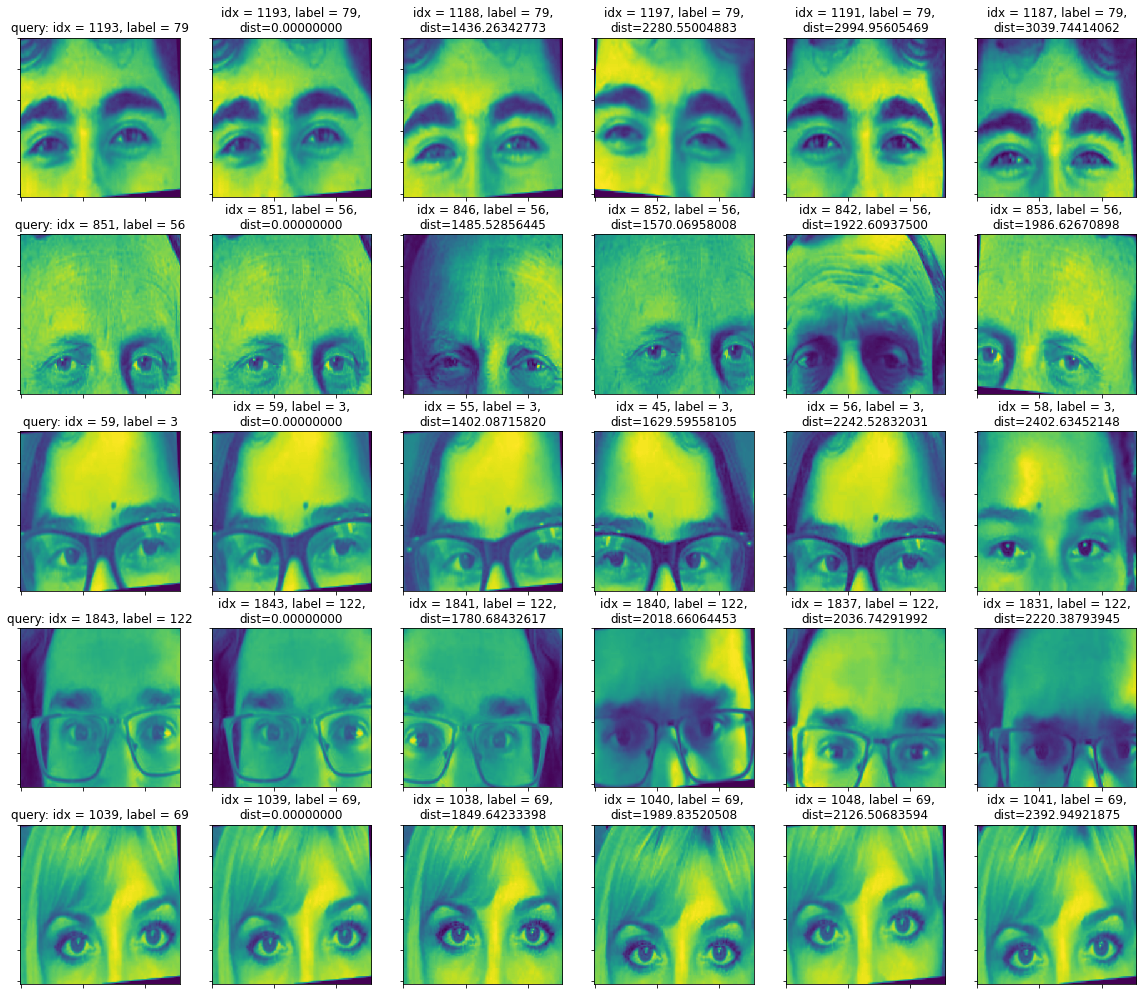

In [131]:
exp.visualize_rankings(exp.embed_train, gt_train_sorted, img_train_sorted,
                       gt_train_sorted, img_train_sorted,
                       best_mlp, 5, figsize=(20, 3.5 * 5))

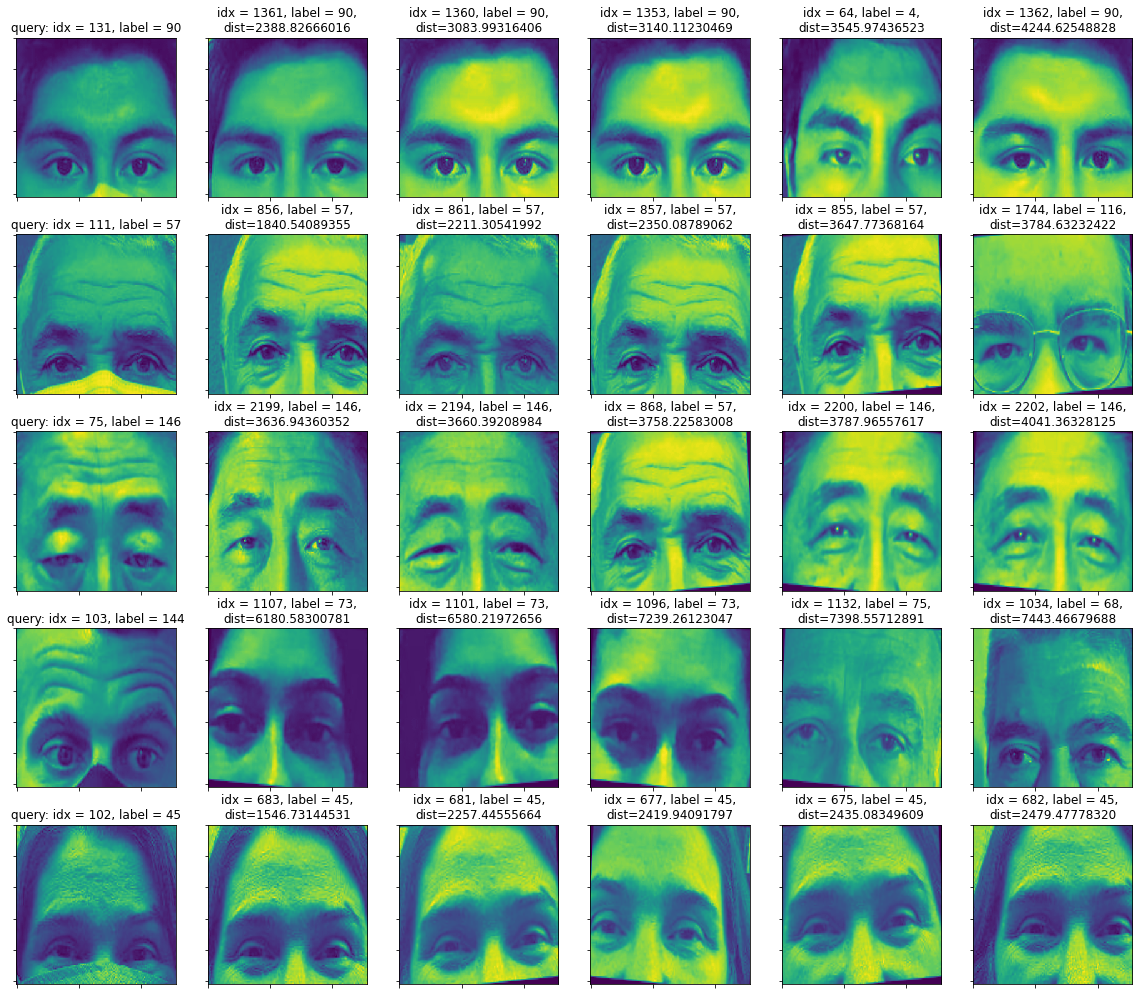

In [132]:
exp.visualize_rankings(exp.embed_val, gt_val, img_val, gt_train_sorted, img_train_sorted,
                       best_mlp, 5, figsize=(20, 3.5 * 5))

In [119]:
exp.evaluate_mlp_val(best_mlp, 5)

0.5240963855421686

In [120]:
exp.evaluate_mlp_test(best_mlp, 5)

0.5180722891566265

In [609]:
exp.evaluate_mlp_test(_mlp, 1)

0.5030120481927711